In [2]:
import numpy as np

from automata.automata_rules import automata_output_list
from automata.schema_search_tools import (
    concatenate,
    annihilation_generation_rules,
    maintenance_rules,
    collect_data_from_generator,)
from cana.boolean_node import BooleanNode

In [3]:
# Define the crossover operation
def crossover(parent1, parent2, prob=0.5):
    """
    Crossover is a genetic operator used to combine the genetic information of two parents to produce new offspring.
    It splits the parent rules into annihilation and generation rules. Then it uses the function switcheroo() to crisscross each line of the rule over a randomly assigned crossover point. It does this with a probability prob for each line.
    Finally, it combines the annihilation and generation rules to form the children rules.

    Parameters:
    parent1: output list of rules
    parent2: output list of rules
    prob: float, crossover probability

    Returns:
    child1: list of schemata rules
    child2: list of schemata rules
    """

    parent1_anni, parent1_gen = annihilation_generation_rules(parent1, split=True)
    parent2_anni, parent2_gen = annihilation_generation_rules(parent2, split=True)
    prob = 0.5
    child1_anni, child2_anni = switcheroo(
        parent1_anni, parent2_anni, prob=prob, type="annihilation"
    )
    child1_gen, child2_gen = switcheroo(
        parent1_gen, parent2_gen, prob=prob, type="generation"
    )
    child1 = child1_anni + child1_gen
    child2 = child2_anni + child2_gen
    return child1, child2


def switcheroo(parent1, parent2, prob=0.5, type=None):
    """
    Switcheroo is a crossover helper. After the parent rules are split into annihilation and generation, they are fed to switcheroo.
    It takes out the middle element of the rule inputs (to ensure that the annihilation or generation aspect is preserved when switching).
    Then with a probability prob, it switches the rules between the parents. Finally, it adds the middle element back to the rules.
    Then it attaches the output values to the rules and returns the children.


    Parameters:
    parent1: list of schemata rules
    parent2: list of schemata rules
    prob: float, crossover probability
    type: str, type of rules that are being switched. Either 'generation' or 'annihilation'

    Returns:
    child1: list of schemata rules
    child2: list of schemata rules
    """
    if type not in ["generation", "annihilation"]:
        raise ValueError("type should be either 'generation' or 'annihilation'")

    # extracting only inputs
    parent1 = [rule[0] for rule in parent1]
    parent2 = [rule[0] for rule in parent2]

    k = len(parent1[0])
    # print(f"Size of the neighbourhood: {k}")
    # check if the neighbourhood size is odd. return error if even
    if k < 3:
        raise ValueError("Neighbourhood size should be at least 3")
    if k % 2 == 0:
        raise ValueError("Neighbourhood size should be odd")

    # removing middle element to preserve annihilations and generations, assuming the total neighborhood size is k
    parent1 = [rule[: k // 2] + rule[((k // 2) + 1) :] for rule in parent1]
    parent2 = [rule[: k // 2] + rule[((k // 2) + 1) :] for rule in parent2]
    # print(f"Parent 1: {parent1}")
    # print(f"Parent 2: {parent2}")

    # crossover
    index = np.random.randint(
        0, k
    )  # taking random crossover point from the length of the first input
    # print(f"Crossover Index: {index}")
    child1 = []
    child2 = []

    for i in range(len(parent1)):
        for j in range(len(parent2)):
            if np.random.rand() < prob:
                child1.append(parent1[i][:index] + parent2[j][index:])
                child2.append(parent2[j][:index] + parent1[i][index:])
    if len(child1) == 0:
        child1 = parent1
    if len(child2) == 0:
        child2 = parent2

    # adding middle element back
    if type == "generation":
        filler = "0"
        not_filler = "1"
    elif type == "annihilation":
        filler = "1"
        not_filler = "0"

    child1 = [[rule[:3] + filler + rule[3:], not_filler] for rule in child1]
    child2 = [[rule[:3] + filler + rule[3:], not_filler] for rule in child2]

    return child1, child2

anni_gen MM401:
[['###1##1', 0], ['##1111#', 0], ['0##0###', 1], ['#0000##', 1]]
anni_gen GP:
[['0##1##0', 0], ['0#01###', 0], ['0##10##', 0], ['###01#1', 1], ['##10##1', 1], ['1##0##1', 1]]


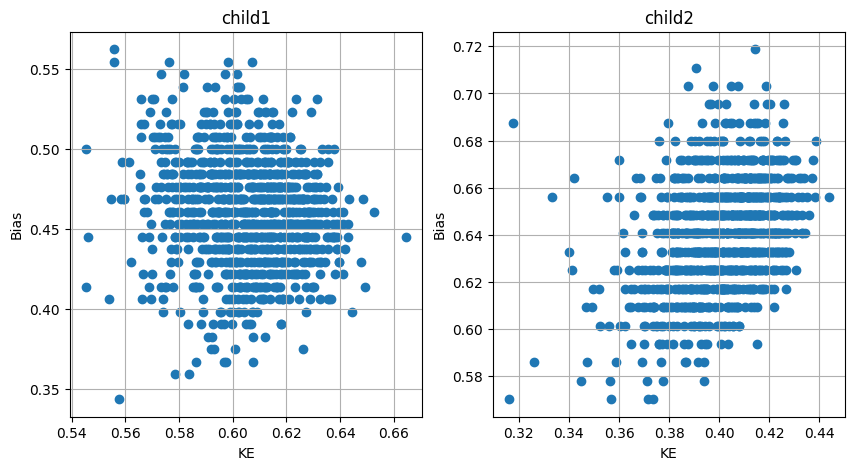

In [11]:
rule1 = "MM401"
rule2 = "GP"
parent1 = automata_output_list[rule1]
print(f"anni_gen {rule1}:\n{annihilation_generation_rules(parent1)}")
parent2 = automata_output_list[rule2]
print(f"anni_gen {rule2}:\n{annihilation_generation_rules(parent2)}")

child1, child2 = crossover(parent1, parent2)
child1 = BooleanNode.from_partial_lut(child1)
child1 = child1.fill_missing_output_randomly()
child2 = BooleanNode.from_partial_lut(child2)
child2 = child2.fill_missing_output_randomly()
generated_nodes = {}
nodes, bias, ke, count = collect_data_from_generator(child1, limit=1000)
generated_nodes["child1"] = {"nodes": nodes, "bias": bias, "ke": ke, "count": count}

nodes, bias, ke, count = collect_data_from_generator(child2, limit=1000)
generated_nodes["child2"] = {"nodes": nodes, "bias": bias, "ke": ke, "count": count}



# plot two  scatter plot of ke and bias for child 1 and child 2
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i , child in enumerate(generated_nodes):
    ke = generated_nodes[child]["ke"]
    bias = generated_nodes[child]["bias"]
    ax[i].scatter(ke, bias)
    ax[i].set_xlabel("KE")
    ax[i].set_ylabel("Bias")
    ax[i].set_title(child)
    ax[i].grid()
plt.show()
